# World Bank API Analysis

Pregunta guía: **¿Qué países mejoraron más su esperanza de vida en 2010-2024 y cómo se relaciona con su PIB per cápita?**

## Plan del análisis

- Países: `USA`, `DEU`, `CHN`, `BRA`, `NGA`
- Indicadores: esperanza de vida, PIB per cápita y población
- Rango temporal: 2010 a 2024

In [29]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

sns.set_theme(style="whitegrid")

BASE_URL = "https://api.worldbank.org/v2"
COUNTRIES = ["USA", "DEU", "CHN", "BRA", "NGA"]
YEARS = (2010, 2024)

INDICATORS = {
    "life_expectancy": "SP.DYN.LE00.IN",
    "gdp_per_capita": "NY.GDP.PCAP.CD",
    "population": "SP.POP.TOTL"
}

In [30]:
def fetch_indicator_data(indicator_code, countries, start_year=2010, end_year=2024, per_page=50, verbose=False):
    country_str = ";".join(countries)
    url = f"{BASE_URL}/country/{country_str}/indicator/{indicator_code}"
    page = 1
    total_pages = 1
    rows = []

    while page <= total_pages:
        params = {
            "format": "json",
            "per_page": per_page,
            "date": f"{start_year}:{end_year}",
            "page": page
        }

        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        payload = response.json()

        if not isinstance(payload, list) or len(payload) < 2 or payload[1] is None:
            break

        metadata = payload[0]
        total_pages = int(metadata.get("pages", 1))
        if verbose:
            print(f"{indicator_code}: pagina {page}/{total_pages}")

        for item in payload[1]:
            year = int(item["date"])
            rows.append({
                "country": item["country"]["value"],
                "countryiso3code": item["countryiso3code"],
                "year": year,
                "value": item["value"],
                "indicator_code": indicator_code
            })

        page += 1

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["value"]).copy()
    df = df.sort_values(["countryiso3code", "year"]).reset_index(drop=True)
    return df

In [31]:
dfs = {}
for name, code in INDICATORS.items():
    dfs[name] = fetch_indicator_data(code, COUNTRIES, YEARS[0], YEARS[1], 50, True)
    print(name, dfs[name].shape)

df_life = dfs["life_expectancy"]
df_gdp = dfs["gdp_per_capita"]
df_pop = dfs["population"]

df_life.head()

SP.DYN.LE00.IN: pagina 1/2
SP.DYN.LE00.IN: pagina 2/2
life_expectancy (70, 5)
NY.GDP.PCAP.CD: pagina 1/2
NY.GDP.PCAP.CD: pagina 2/2
gdp_per_capita (75, 5)
SP.POP.TOTL: pagina 1/2
SP.POP.TOTL: pagina 2/2
population (75, 5)


,country,countryiso3code,year,value,indicator_code
0,Brazil,BRA,2010,73.779,SP.DYN.LE00.IN
1,Brazil,BRA,2011,74.047,SP.DYN.LE00.IN
2,Brazil,BRA,2012,74.335,SP.DYN.LE00.IN
3,Brazil,BRA,2013,74.609,SP.DYN.LE00.IN
4,Brazil,BRA,2014,74.823,SP.DYN.LE00.IN


## Cambio de esperanza de vida (2010 vs último año disponible común)

In [32]:
start_year = YEARS[0]
end_year_common = int(df_life.groupby("countryiso3code")["year"].max().min())
print(f"Año inicial: {start_year} | Último año común: {end_year_common}")

life_start = (
    df_life[df_life["year"] == start_year][["countryiso3code", "value"]]
    .rename(columns={"value": f"life_{start_year}"})
)

life_end = (
    df_life[df_life["year"] == end_year_common][["countryiso3code", "country", "value"]]
    .rename(columns={"value": f"life_{end_year_common}"})
)

life_change = life_end.merge(life_start, on="countryiso3code", how="inner")
life_change["life_change"] = life_change[f"life_{end_year_common}"] - life_change[f"life_{start_year}"]
life_change = life_change.sort_values("life_change", ascending=False).reset_index(drop=True)

life_change

Año inicial: 2010 | Último año común: 2023


,countryiso3code,country,life_2023,life_2010,life_change
0,NGA,Nigeria,54.462000,51.315000,3.147000
1,CHN,China,77.953000,75.668000,2.285000
2,BRA,Brazil,75.848000,73.779000,2.069000
3,DEU,Germany,80.541463,79.987805,0.553659
4,USA,United States,78.385366,78.541463,-0.156098


In [33]:
life_end

,countryiso3code,country,life_2023
13,BRA,Brazil,75.848000
27,CHN,China,77.953000
41,DEU,Germany,80.541463
55,NGA,Nigeria,54.462000
69,USA,United States,78.385366


## Relación con PIB per cápita (2010 vs 2023)

In [34]:
gdp_start_year = 2010
gdp_end_year = 2023

gdp_start = (
    df_gdp[df_gdp["year"] == gdp_start_year][["countryiso3code", "value"]]
    .rename(columns={"value": f"gdp_pc_{gdp_start_year}"})
)

gdp_end = (
    df_gdp[df_gdp["year"] == gdp_end_year][["countryiso3code", "value"]]
    .rename(columns={"value": f"gdp_pc_{gdp_end_year}"})
)

gdp_compare = gdp_start.merge(gdp_end, on="countryiso3code", how="inner")
gdp_compare["gdp_change_2010_2023"] = gdp_compare[f"gdp_pc_{gdp_end_year}"] - gdp_compare[f"gdp_pc_{gdp_start_year}"]

analysis_df = life_change.merge(gdp_compare, on="countryiso3code", how="left")
analysis_df = analysis_df[["country", "countryiso3code", f"life_{start_year}", f"life_{end_year_common}", "life_change", f"gdp_pc_{gdp_start_year}", f"gdp_pc_{gdp_end_year}", "gdp_change_2010_2023"]]
analysis_df.sort_values("life_change", ascending=False)

,country,countryiso3code,life_2010,life_2023,life_change,gdp_pc_2010,gdp_pc_2023,gdp_change_2010_2023
0,Nigeria,NGA,51.315000,54.462000,3.147000,2202.256730,2138.763837,-63.492892
1,China,CHN,75.668000,77.953000,2.285000,4629.245517,12951.178240,8321.932723
2,Brazil,BRA,73.779000,75.848000,2.069000,11403.284004,10377.589772,-1025.694232
3,Germany,DEU,79.987805,80.541463,0.553659,42396.966598,54776.766824,12379.800226
4,United States,USA,78.541463,78.385366,-0.156098,48642.610018,81032.262118,32389.652100


## Visualización 1: evolución de esperanza de vida

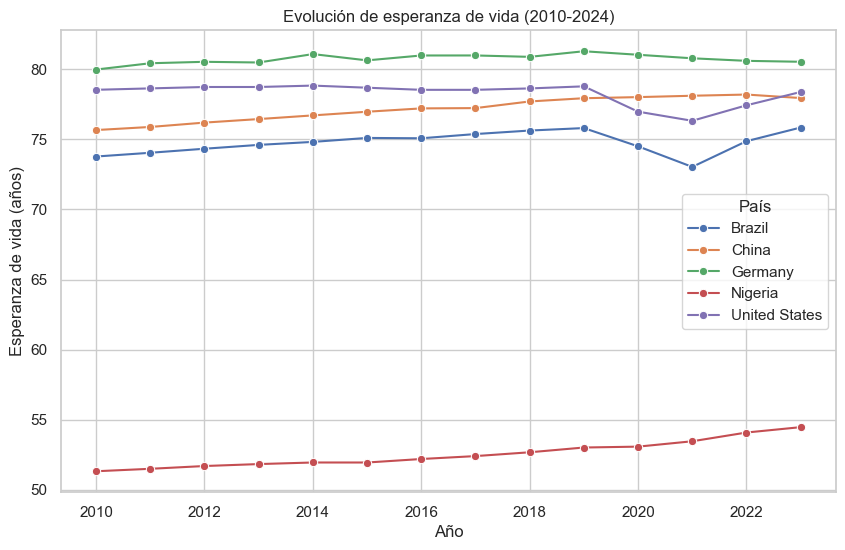

In [35]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_life, x="year", y="value", hue="country", marker="o")
plt.title("Evolución de esperanza de vida (2010-2024)")
plt.xlabel("Año")
plt.ylabel("Esperanza de vida (años)")
plt.legend(title="País")
plt.show()

## Visualización 2: mejora en esperanza de vida vs PIB per cápita

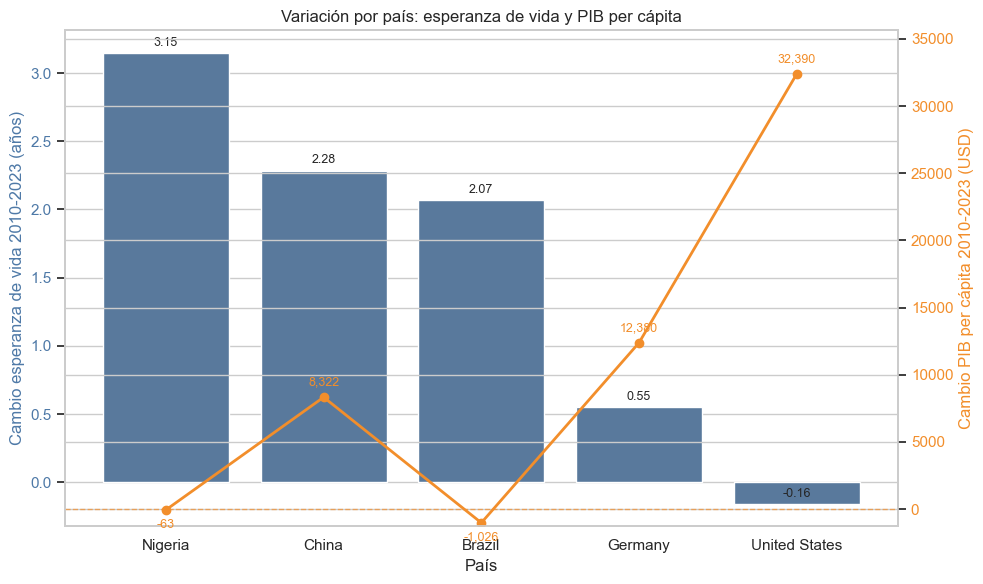

In [36]:
plot_df = analysis_df.sort_values("life_change", ascending=False).copy()
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(data=plot_df, x="country", y="life_change", color="#4E79A7", ax=ax1)
ax1.set_title("Variación por país: esperanza de vida y PIB per cápita")
ax1.set_xlabel("País")
ax1.set_ylabel(f"Cambio esperanza de vida {start_year}-{end_year_common} (años)", color="#4E79A7")
ax1.tick_params(axis="y", labelcolor="#4E79A7")

for i, value in enumerate(plot_df["life_change"]):
    ax1.text(i, value + 0.03, f"{value:.2f}", ha="center", va="bottom", fontsize=9)

ax2 = ax1.twinx()
gdp_values = plot_df["gdp_change_2010_2023"]
ax2.plot(plot_df["country"], gdp_values, color="#F28E2B", marker="o", linewidth=2)
ax2.set_ylabel("Cambio PIB per cápita 2010-2023 (USD)", color="#F28E2B")
ax2.tick_params(axis="y", labelcolor="#F28E2B")
ax2.axhline(0, color="#F28E2B", linestyle="--", linewidth=1, alpha=0.7)

# Fuerza a que el eje derecho muestre claramente valores negativos y positivos.
gdp_min = float(gdp_values.min())
gdp_max = float(gdp_values.max())
lower = gdp_min * 1.25 if gdp_min < 0 else -max(500, gdp_max * 0.05)
upper = gdp_max * 1.10 if gdp_max > 0 else max(500, abs(gdp_min) * 0.10)
ax2.set_ylim(lower, upper)

offset = max(abs(gdp_min), abs(gdp_max)) * 0.02
for i, value in enumerate(gdp_values):
    y = value + offset if value >= 0 else value - offset
    va = "bottom" if value >= 0 else "top"
    ax2.text(i, y, f"{value:,.0f}", color="#F28E2B", ha="center", va=va, fontsize=9)

fig.tight_layout()
plt.show()

## Carga a SQLite

In [37]:
engine = create_engine("sqlite:///world_bank_analysis.db")

df_life.to_sql("indicator_life_expectancy", con=engine, if_exists="replace", index=False)
df_gdp.to_sql("indicator_gdp_per_capita", con=engine, if_exists="replace", index=False)
df_pop.to_sql("indicator_population", con=engine, if_exists="replace", index=False)
analysis_df.to_sql("analysis_life_vs_gdp", con=engine, if_exists="replace", index=False)

pd.read_sql("SELECT * FROM analysis_life_vs_gdp LIMIT 5", con=engine)

,country,countryiso3code,life_2010,life_2023,life_change,gdp_pc_2010,gdp_pc_2023,gdp_change_2010_2023
0,Nigeria,NGA,51.315000,54.462000,3.147000,2202.256730,2138.763837,-63.492892
1,China,CHN,75.668000,77.953000,2.285000,4629.245517,12951.178240,8321.932723
2,Brazil,BRA,73.779000,75.848000,2.069000,11403.284004,10377.589772,-1025.694232
3,Germany,DEU,79.987805,80.541463,0.553659,42396.966598,54776.766824,12379.800226
4,United States,USA,78.541463,78.385366,-0.156098,48642.610018,81032.262118,32389.652100


## Hallazgos (completar al ejecutar)

1. País con mayor mejora de esperanza de vida: ...
2. Relación observada con PIB per cápita: ...
3. Diferencias destacadas entre países: ...